Saving archive (2).zip to archive (2).zip
Found 52 CSV files.


<ipython-input-1-d43cbd83a010>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(df_list, ignore_index=True)


Combined data shape: (470434, 18)
Numeric columns retained: ['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']
Training samples: 192549, Testing samples: 48138
HistGradientBoostingRegressor MSE: 24448.2571
HistGradientBoostingRegressor R-squared: 0.9980


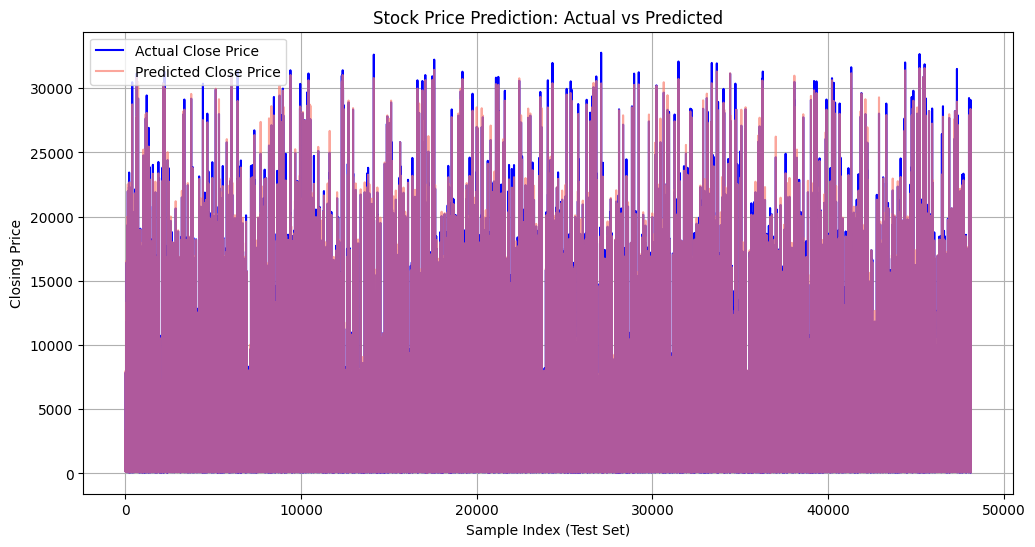

In [1]:
# Upload the ZIP file
from google.colab import files
uploaded = files.upload()

import pandas as pd
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Automatically detect ZIP file from uploaded files
zip_path = next((name for name in uploaded if name.endswith('.zip')), None)
if zip_path is None:
    raise ValueError("No ZIP file uploaded.")

extract_dir = 'stock_data_temp'
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Collect CSV files from the extracted folder
all_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith('.csv')]
print(f'Found {len(all_files)} CSV files.')

# Combine all CSVs
df_list = []
for file in all_files:
    try:
        df = pd.read_csv(file, encoding='utf-8')
        df_list.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Concatenate all DataFrames
data = pd.concat(df_list, ignore_index=True)
print(f'Combined data shape: {data.shape}')

# Drop non-numeric columns
data = data.select_dtypes(include=[np.number])
print(f'Numeric columns retained: {data.columns.tolist()}')

# Add lag features for 'Close'
if 'Close' not in data.columns:
    raise KeyError("The 'Close' column is missing from the dataset.")

for lag in range(1, 4):
    data[f'Close_lag_{lag}'] = data['Close'].shift(lag)

# Drop rows with NaN values caused by lagging
data.dropna(inplace=True)

# Add target column for next day Close
data['Close_next'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Feature columns
feature_cols = [
    col for col in [
        'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume',
        'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble', 'HL_PCT', 'PCT_change',
        'Close_lag_1', 'Close_lag_2', 'Close_lag_3'
    ] if col in data.columns  # Keep only those that exist
]

# Prepare input and output
X = data[feature_cols]
y = data['Close_next']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

# Train the model
gb_model = HistGradientBoostingRegressor(max_iter=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_gb = gb_model.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'HistGradientBoostingRegressor MSE: {mse_gb:.4f}')
print(f'HistGradientBoostingRegressor R-squared: {r2_gb:.4f}')

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred_gb, label='Predicted Close Price', color='salmon', alpha=0.7)
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Sample Index (Test Set)')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()